# Создание датасета игральных карт

ref: https://github.com/geaxgx

## Измерение размеров карт

In [1]:
# Размеры карт в миллиметрах
cardW = 55
cardH = 85
cornerXmin = 1.5
cornerXmax = 10
cornerYmin = 3.5
cornerYmax = 23 # 21mm + 2mm

# Конвертируем измерения из мм в пиксели
zoom = 4
cardW *= zoom
cardH *= zoom
cornerXmin = int(cornerXmin*zoom)
cornerXmax = int(cornerXmax*zoom)
cornerYmin = int(cornerYmin*zoom)
cornerYmax = int(cornerYmax*zoom)

## Импорты

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon

## Дополнительные функции

In [3]:

def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

## Глобальные переменные

In [4]:
data_dir="data" # Директория со всеми данными

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# Pickle файл содержащий изображения из DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle файл содержащий изображения карт
cards_pck_fn=data_dir+"/cards.pck"


# imgW,imgH: размеры полученных изображений датасета
imgW=720
imgH=720


refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])


## Загружаем изображения из Describable Textures Dataset (DTD)
Для создания разнообразного фона на будущих изображениях датасета

In [5]:
!tar xf dtd-r1.0.1.tar.gz

### Сохраняем все .jpg файлы в формате pickle
Чтобы в дальнейшем подгружать их c .pkl файла

In [6]:
dtd_dir="dtd/images/"
bg_images=[]
for subdir in glob(dtd_dir+"/*"):
    for f in glob(subdir+"/*.jpg"):
        bg_images.append(mpimg.imread(f))
print("Nb of images loaded :",len(bg_images))
print("Saved in :",backgrounds_pck_fn)
pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

Nb of images loaded : 5640
Saved in : data/backgrounds.pck


### Создаем класс Backgrouds


In [7]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()

Nb of images loaded : 5640


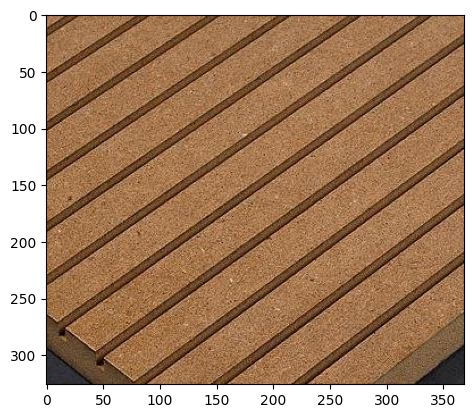

In [8]:
# Попробуем получить случайное изображение из класса:
_=backgrounds.get_random(display=True)

## Извлечение изображений карт из фотографий или видео

### Создаем alphamask
Для создания ровных и прозрачных границ распознанных карт

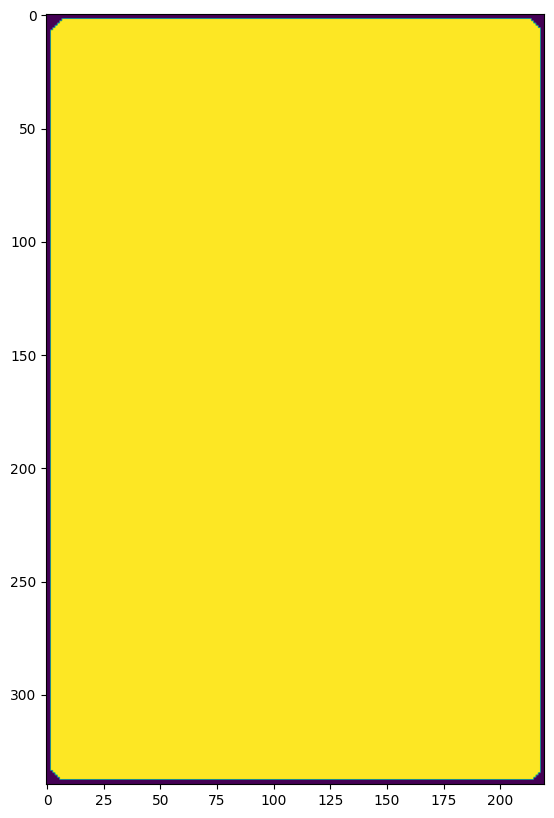

In [9]:
bord_size=2
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

## Фунция exctraction_card
Используется для извлечения из изображения той части, где находится карта и преобразования ее 
в соответствии с эталонной формой карты.

Предполагается, что пользователь максимально облегчит задачу алгоритму, сделав фон изображения карточки максимально простым, однотонным, без размытия и с хорошим освещением

In [17]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

def extract_card (img, output_fn=None, min_focus=120, debug=False):
    """
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    # Convert in gray color
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,11,17,17)
    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)
    
    # Find the contours in the edged image
    cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int0(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)
        
        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)
        
    if debug:
        cv2.imshow("Gray",gray)
        cv2.imshow("Canny",edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[box],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnt],0,(0,255,0),-1)
        cv2.imshow("Contour with biggest area",edge_bgr)
        if valid:
            cv2.imshow("Alphachannel",alphachannel)
            cv2.imshow("Extracted card",imgwarp)

    return valid,imgwarp

C:\Users\Тима\AppData\Local\Temp\ipykernel_2440\1543008984.py:42: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box=np.int0(box)


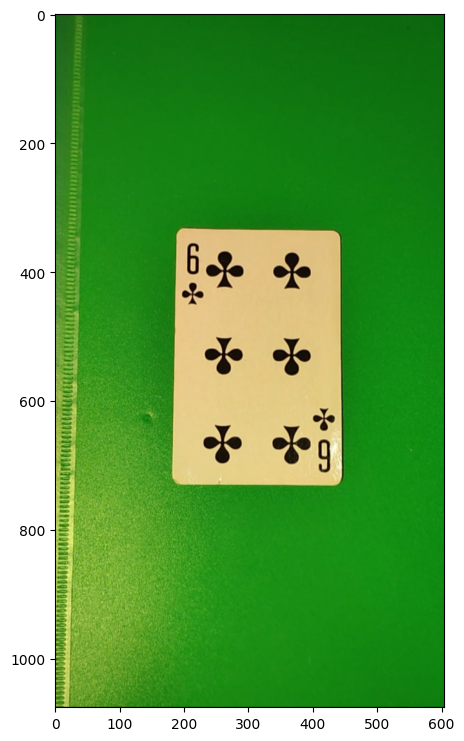

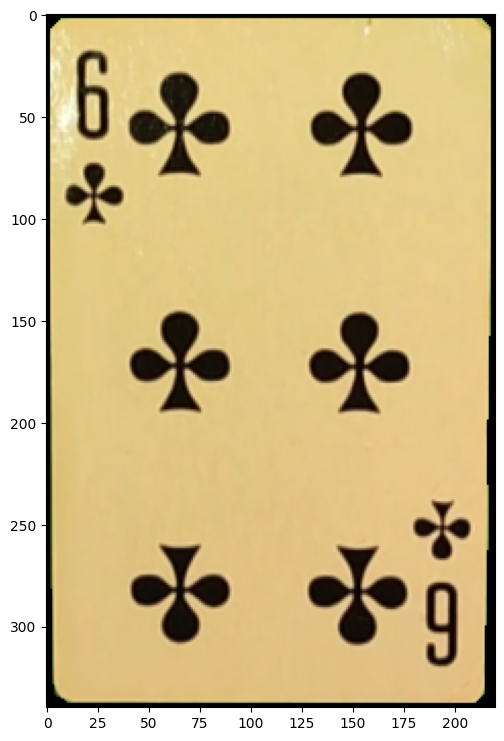

In [18]:
# Test on one image
debug=False
img=cv2.imread("data/6c.png")
display_img(img)
valid,card=extract_card(img,"data/extracted_card.png", debug=debug)
if valid:
    display_img(card)
if debug:
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [11]:
def extract_cards_from_video(video_fn, output_dir=None, keep_ratio=5, min_focus=120, debug=False):
    """
        Extract cards from media file 'video_fn' 
        If 'output_dir' is specified, the cards are saved in 'output_dir'.
        One file per card with a random file name
        Because 2 consecutives frames are probably very similar, we don't use every frame of the video, 
        but only one every 'keep_ratio' frames
        
        Returns list of extracted images
    """
    if not os.path.isfile(video_fn):
        print(f"Video file {video_fn} does not exist !!!")
        return -1,[]
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cap=cv2.VideoCapture(video_fn)
    
    frame_nb=0
    imgs_list=[]
    while True:
        ret,img=cap.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                output_fn=give_me_filename(output_dir,"png")
            else:
                output_fn=None
            valid,card_img = extract_card(img,output_fn,min_focus=min_focus,debug=debug)
            if debug: 
                k=cv2.waitKey(1)
                if k==27: break
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    
    if debug:
        cap.release()
        cv2.destroyAllWindows()
    
    return imgs_list
            
        
        

In [19]:
# Test card extraction from a video   
imgs=extract_cards_from_video("data/6c.mp4",output_dir="data/6c",debug=True)
print("Nb images extracted:",len(imgs))

C:\Users\Тима\AppData\Local\Temp\ipykernel_2440\1543008984.py:42: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box=np.int0(box)


Nb images extracted: 37
